# Exercise 1 computer assignments

Fill in the parts labeled **your solution here** and replace *...* with your code. You *do not* need to strictly follow the template, but you may lose points if you do not provide the required results.

## 1 Basic definitions

In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### (a)

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

class Net(nn.Module):
    def __init__(self, activation) -> None: 
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(5, 5, bias=False),
            activation,
            nn.Linear(5, 5, bias=False),
            activation,
            nn.Linear(5, 5, bias=False),
            activation            
        )
    
    def forward(self, x: torch.tensor) -> torch.tensor:
        return self.layers(x)
    
    def assign_weights(self, w: torch.tensor) -> None:
        """Assigns new weights to the 3 linear layers. The dim of w is expected to be (3, 5, 5)."""
        for i in range(3):
            # every second layer is a linear layer
            self.layers[i*2].weight = nn.Parameter(w[i])
    
tanhnet = Net(nn.Tanh()).to(device)
relunet = Net(nn.ReLU()).to(device)
linearnet = Net(nn.Identity()).to(device)

#### (b)

In [3]:
# seed for reproducibility
torch.manual_seed(1)

# n numbers between -10 and 10 for the values of x1
n = 50
x1 = torch.linspace(-10, 10, n).reshape(n, 1)
# rest of x_i is random but kept fixed while changing x1
x = torch.stack([torch.rand(4)]*n)
# concatenate together to form the input
X = torch.cat((x1, x), dim=1).to(device)

In [4]:
# create 3 sets of uniformly distributed random weight vectors
w1 = torch.rand(3, 5, 5, device=device)
w2 = torch.rand(3, 5, 5, device=device)
w3 = torch.rand(3, 5, 5, device=device)

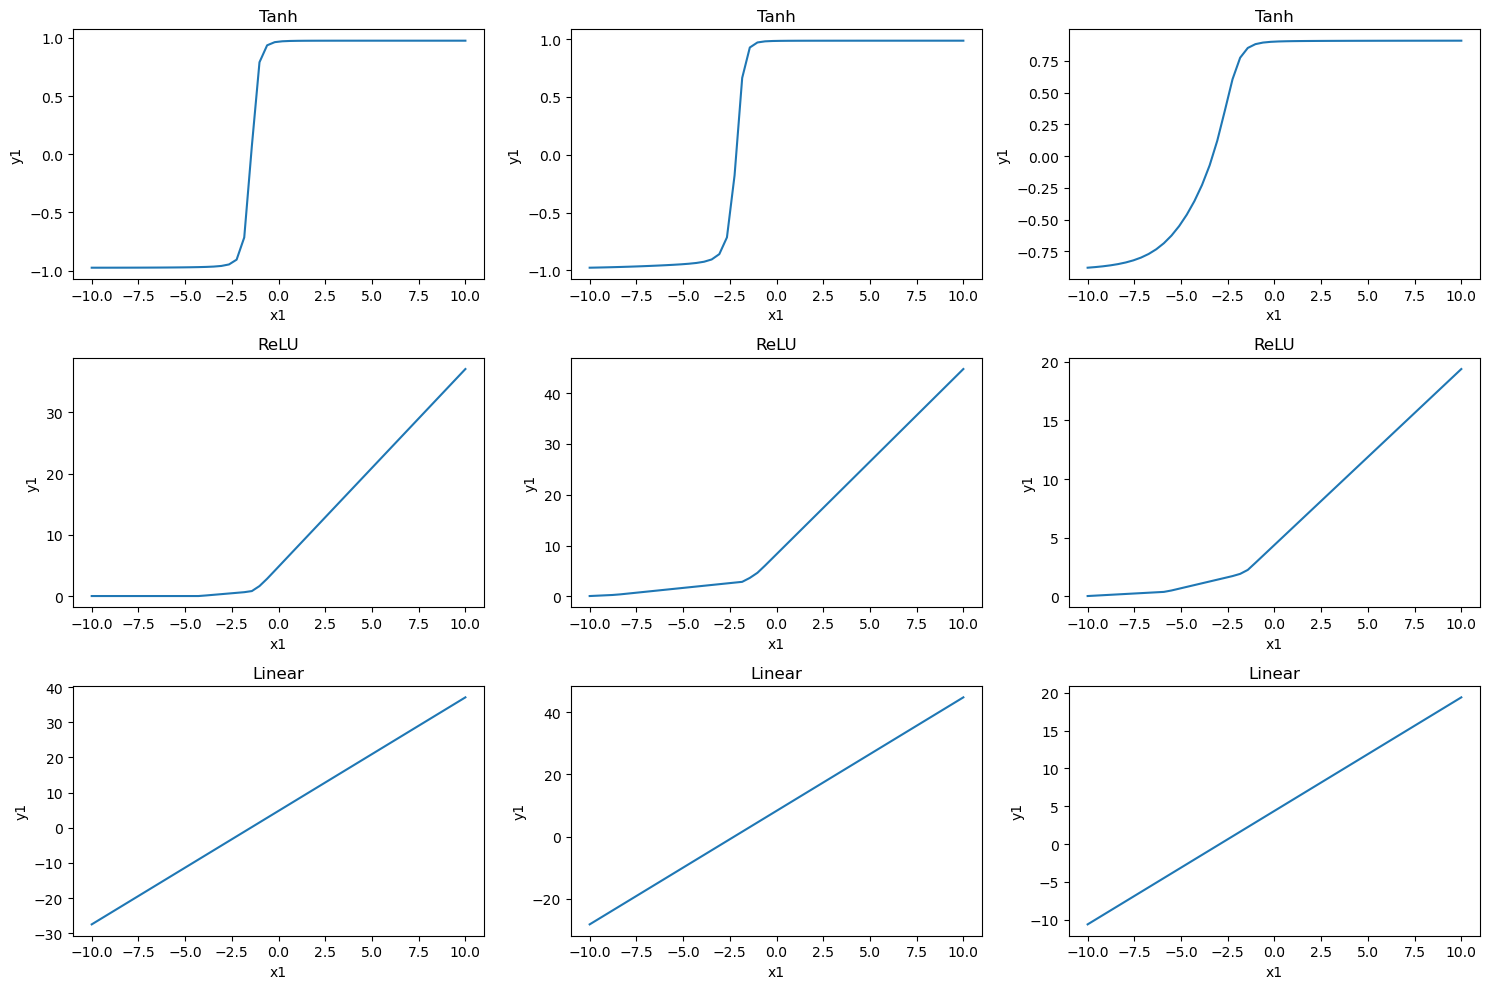

In [5]:
plot_titles = "Tanh ReLU Linear".split()
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
for i, net in enumerate([tanhnet, relunet, linearnet]):
    for j, w in enumerate([w1, w2, w3]):
        net.assign_weights(w)
        with torch.no_grad():
            # get only first component of the output
            y1 = net(X)[:, 0]
            axs[i, j].plot(x1.cpu(), y1.cpu())
            axs[i, j].set_title(plot_titles[i])
            axs[i, j].set_xlabel('x1')
            axs[i, j].set_ylabel('y1')
plt.tight_layout()
plt.show() 



## 2 Optimization

### 1.

In [6]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(1)

#### (a)

In [7]:
def f(w: np.array) -> float:
    return np.exp(-w[0]**2 - 2*(w[1] - 1)**2) + np.exp(-(w[0] - 1)**2 - 2*w[1]**2)

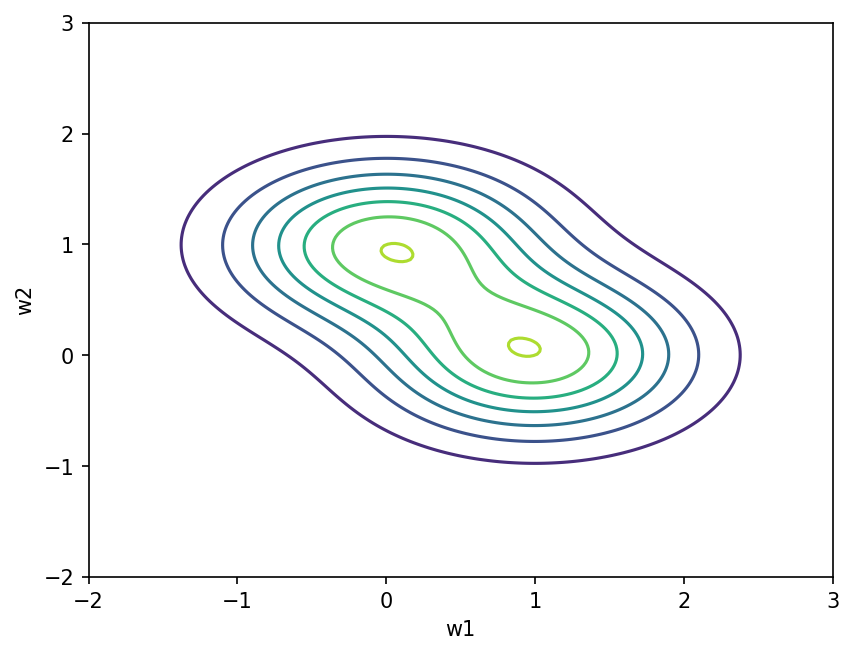

In [8]:

# Code for plotting isocontours of the function f
vec_f = np.vectorize(f, signature="(n)->()")
w1 = np.linspace(-2.0, 3.0, 200)
w2 = np.linspace(-2.0, 3.0, 200)
W1, W2 = np.meshgrid(w1, w2)
Fs = vec_f(np.stack((W1, W2), axis=2))
plt.figure(dpi=150)
plt.contour(W1, W2, Fs)
plt.xlabel("w1")
plt.ylabel("w2")
plt.show()

#### (b)

$$
\begin{align*}
f(\textbf{w})&=\exp (-w_1^2 - 2(w_2 - 1)^2) + \exp (-(w_1-1)^2-2w_2) \\
&= \exp (-w_1^2 - 2w_2^2 + 4w_2 -2) + \exp (-w_1^2+2w_1-2w_2^2-1) 
\end{align*}
$$

The gradient is then
$$
\begin{align*}
\nabla f &=\frac{\partial f}{\partial w_1} \textbf{i} + \frac{\partial f}{\partial w_2} \textbf{j} \\
&= \left[ -2w_1 \exp (-w_1^2 -2w_2^2 + 4w_2 -2 ) + (2 - 2w_1) \exp (-w_1^2 + 2w_1 -2w_2^2 -1) \right] \textbf{i} \\
&+ \left[ (4 -4w_2)\exp (-w_1^2 -2w_2^2 + 4w_2 -2 ) - 4w_2 \exp (-w_1^2 + 2w_1 -2w_2^2 -1) \right] \textbf{j}
\end{align*}
$$

In [9]:
def grad_f(w: np.array) -> np.array:
    w1, w2 = w[0], w[1]
    i = -2*w1*np.exp(-w1**2 - 2*w2**2 + 4*w2 - 2) + (2 - 2*w1)*np.exp(-w1**2 + 2*w1 - 2*w2**2 - 1)
    j = (4 - 4*w2)*np.exp(-w1**2 - 2*w2**2 + 4*w2 - 2) - 4*w2*np.exp(-w1**2 + 2*w1 - 2*w2**2 - 1)
    return np.array([i, j])

#### (c)

In [10]:
w1 = np.asarray([0.2, 0.5])
w2 = np.asarray([0.5, 0.2])
w3 = np.asarray([1.0, 1.0])

def gradient_method(w_init: np.array, stepsize: float) -> tuple[list, list]:
    w = w_init
    w_vals = [w]
    f_vals = [f(w)]

    while True:
        w = w + stepsize*grad_f(w)
        w_vals.append(w) 
        f_vals.append(f(w))
        # stop when the vector w doesn't change significantly anymore
        if np.abs(w_vals[-1][0] - w_vals[-2][0]) < 0.0001 and np.abs(w_vals[-1][1] - w_vals[-2][1]) < 0.0001:
            break

    return (np.array(w_vals), f_vals)

# this is about as high as you can go in terms of stepsize while still converging smoothly
step = 0.4

w_vals, f_vals = zip(*[gradient_method(w, step) for w in [w1, w2, w3]])

#### (d)

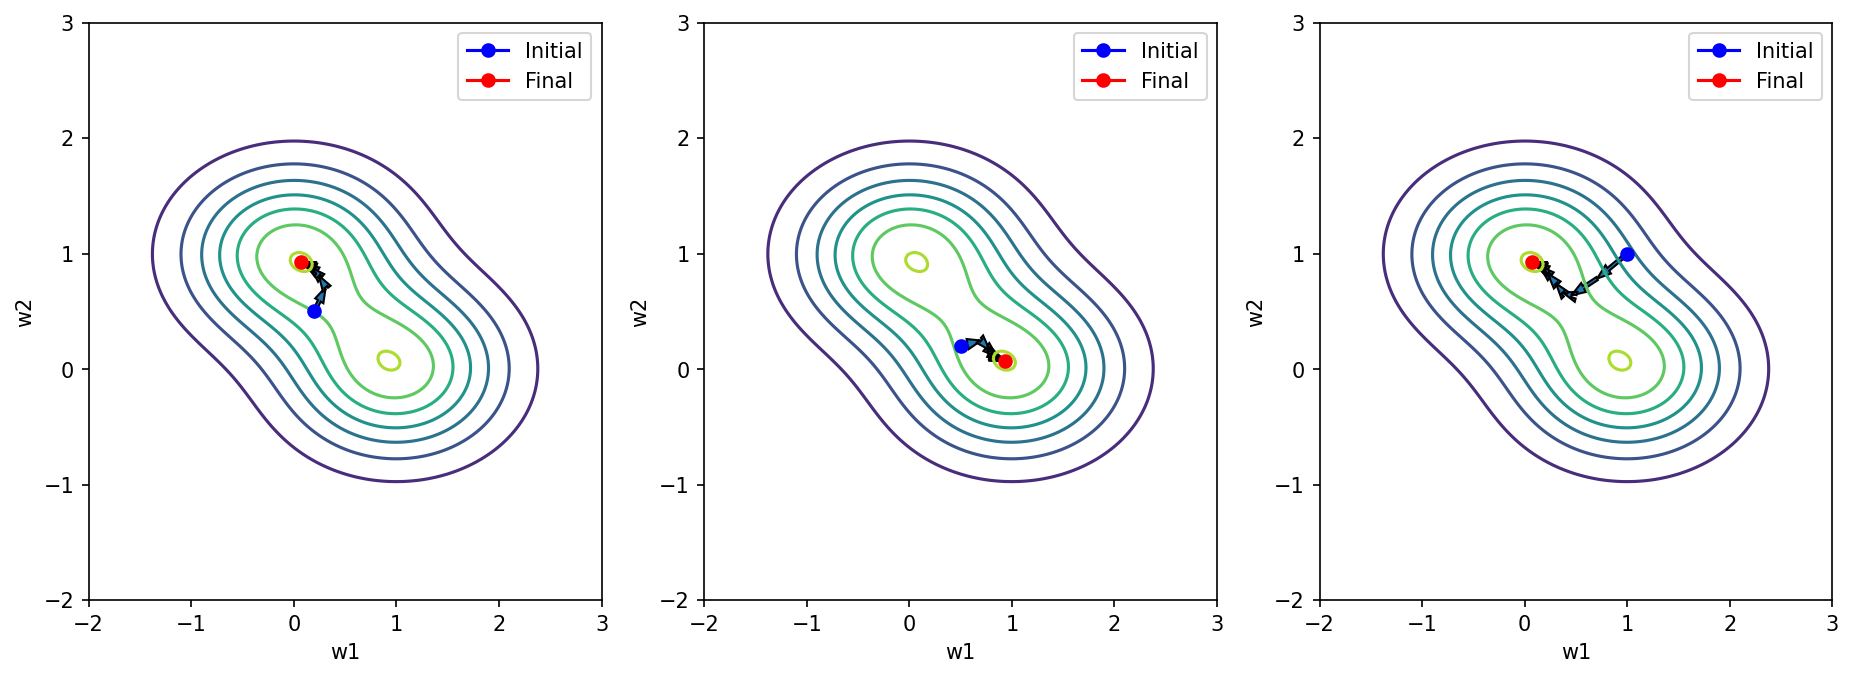

In [11]:
# Code for plotting.
fig, axes = plt.subplots(1, 3, figsize=(15, 5), dpi=150)
for i, w in enumerate(w_vals):
    ax = axes[i]
    ax.contour(W1, W2, Fs)
    ax.plot(w[0, 0], w[0, 1], marker="o", color="blue", label="Initial")

    for j in range(len(w) - 1):
        x = w[j, 0]
        y = w[j, 1]
        dx = w[j+1, 0] - x
        dy = w[j+1, 1] - y 
        ax.arrow(x, y, dx, dy, length_includes_head=True, width=0.03)
    
    ax.plot(w[-1, 0], w[-1, 1], marker="o", color="red", label="Final")

    ax.set_xlabel("w1")
    ax.set_ylabel("w2")
    ax.legend()
plt.show()

#### (e)

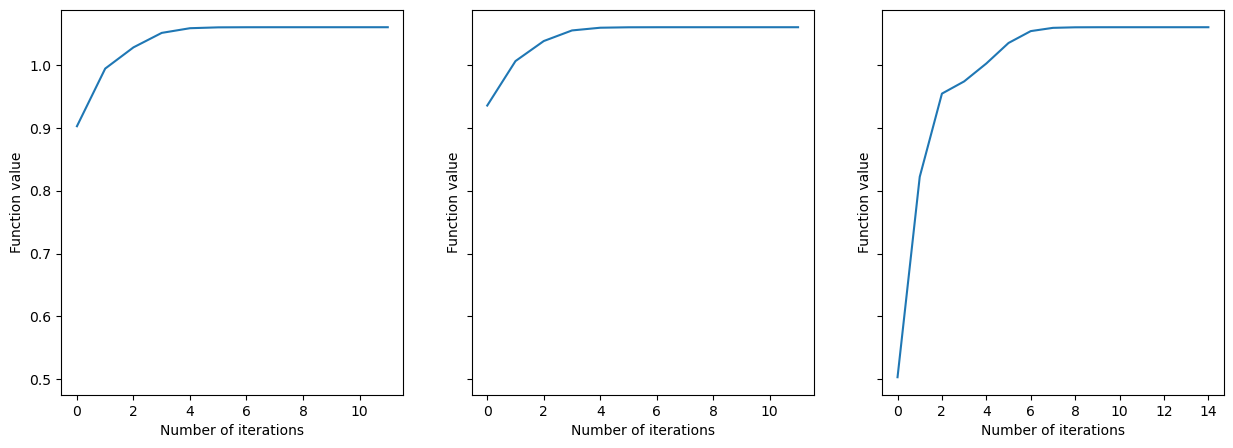

In [12]:
# Code for plotting.
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
for i, vals in enumerate(f_vals):
    axs[i].plot(range(len(vals)), vals)
    axs[i].set_xlabel("Number of iterations")
    axs[i].set_ylabel("Function value")
plt.show()

#### (f)

The function $f(\textbf{w})$ does not have a global maximum, but two local maxima. The algorithm converges correctly to either of the local maxima, but which one it chooses depends on the initial point $\textbf{w}_0$, since the direction of steepest ascent is towards the closest maximum.